In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
import math
import time
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

sns.set_style("whitegrid")

### Part 1: Data Pre-processing

In [2]:
df = pd.read_csv("../resources/data/discords/memory/memory.txt",header=None,names=['values'])
df['anomaly'] = 0
df

values  anomaly
0     1.461180        0
1     1.405110        0
2     1.319480        0
3     1.287950        0
4     1.281960        0
...        ...      ...
6870  0.126111        0
6871  0.087128        0
6872  0.088258        0
6873  0.109876        0
6874  0.139097        0

[6875 rows x 2 columns]

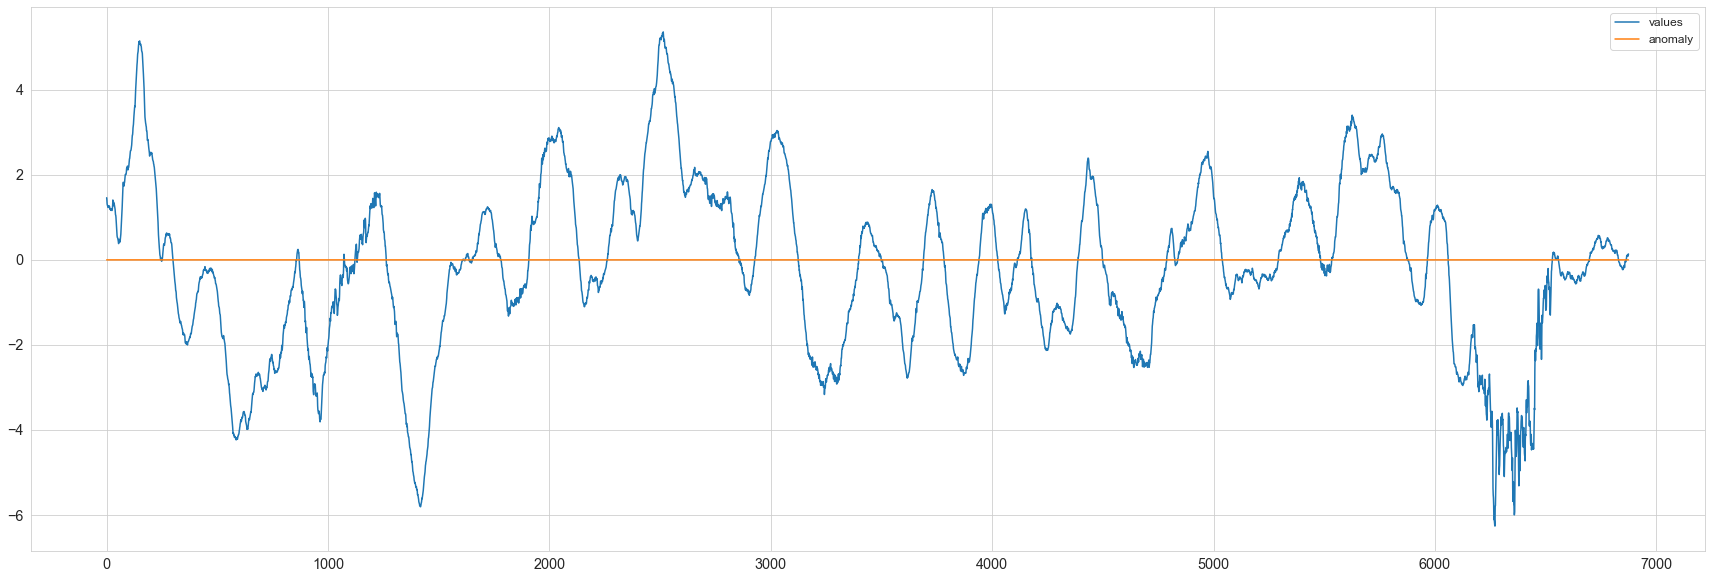

In [3]:
df.plot(figsize=(30,10))
plt.show()

In [4]:
print(df.shape)

(6875, 2)


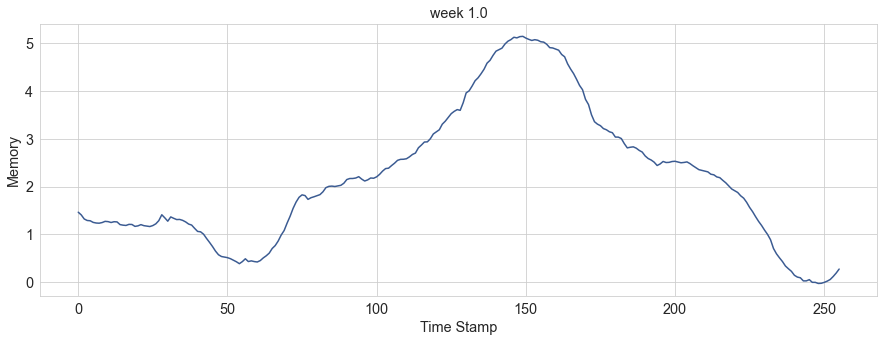

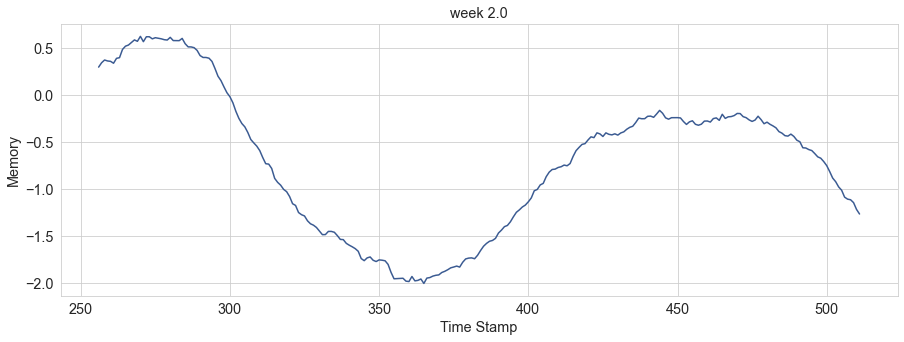

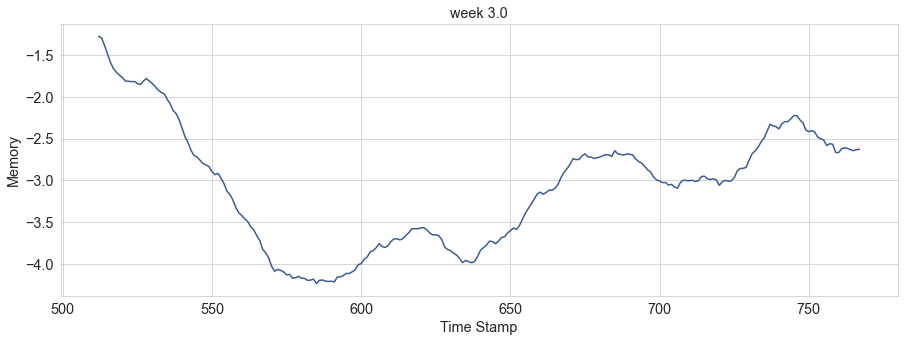

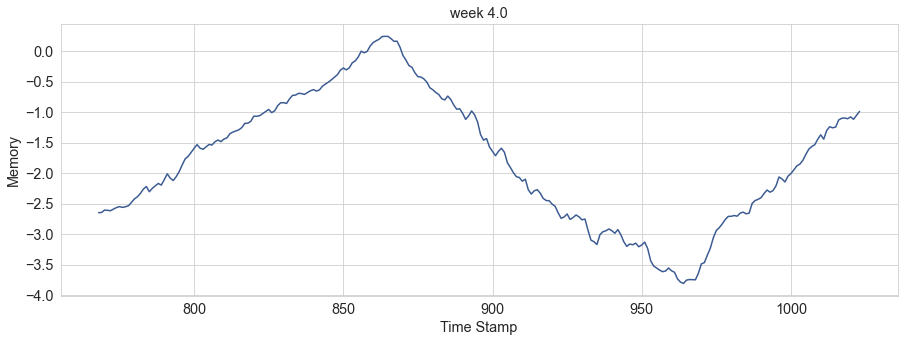

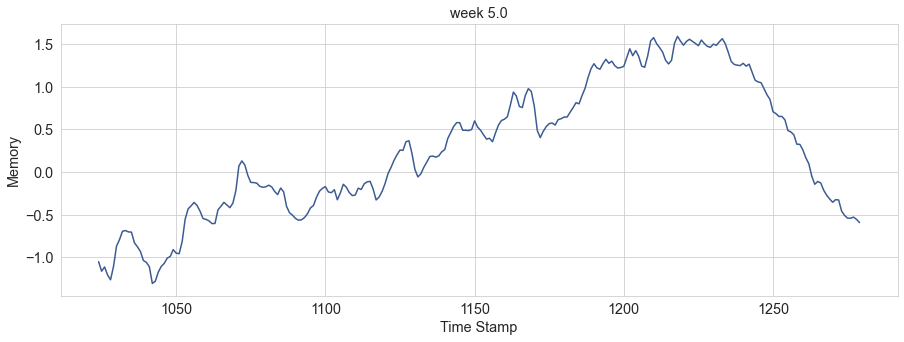

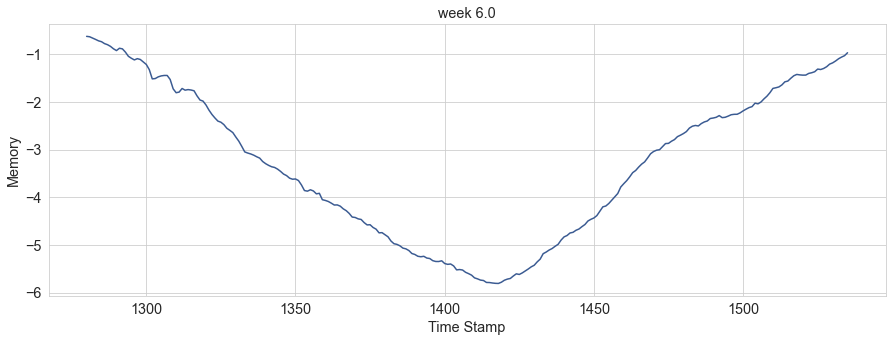

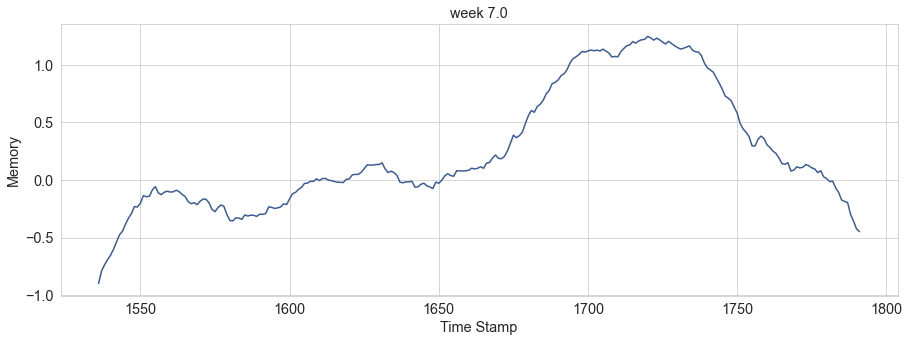

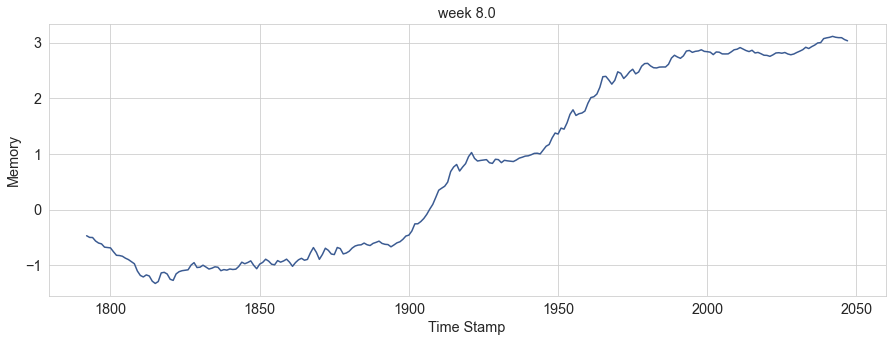

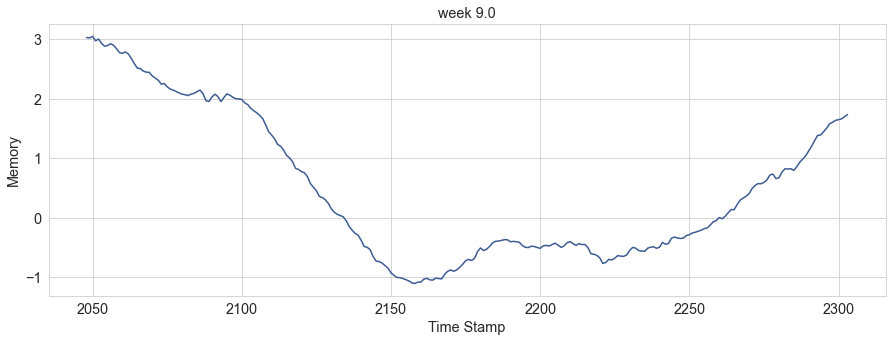

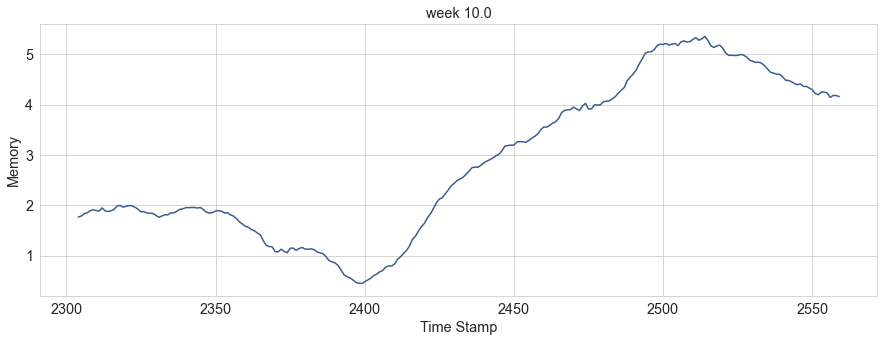

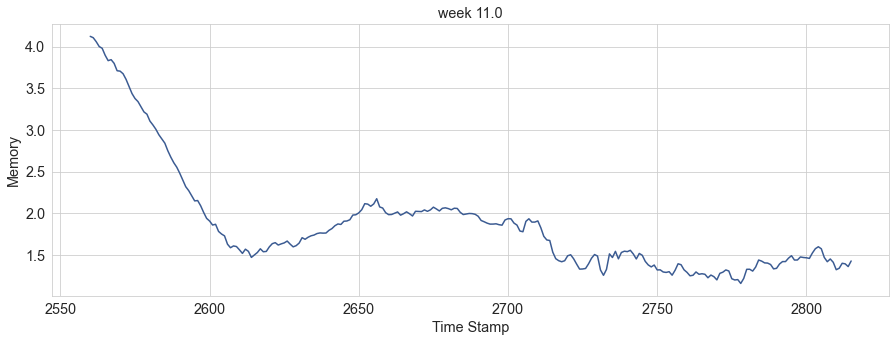

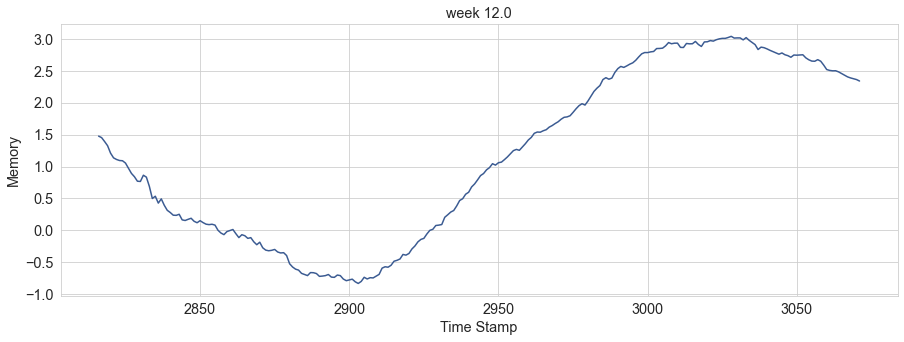

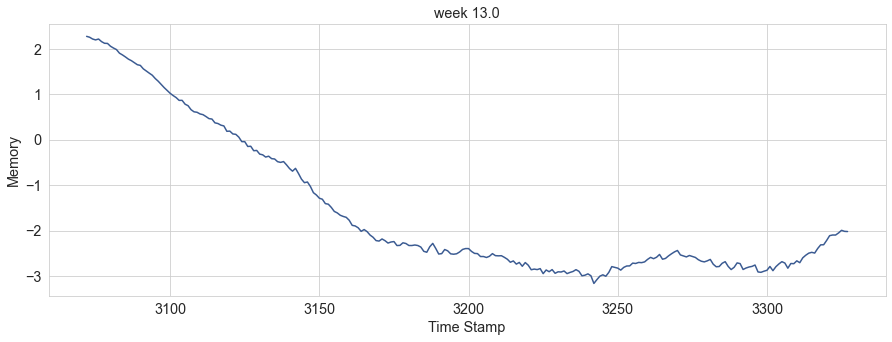

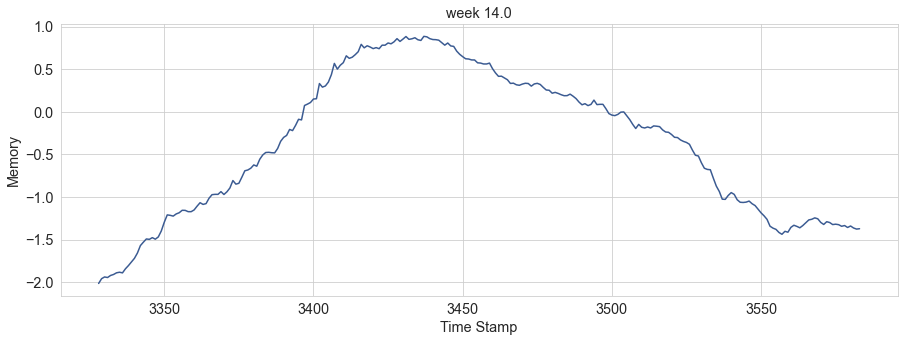

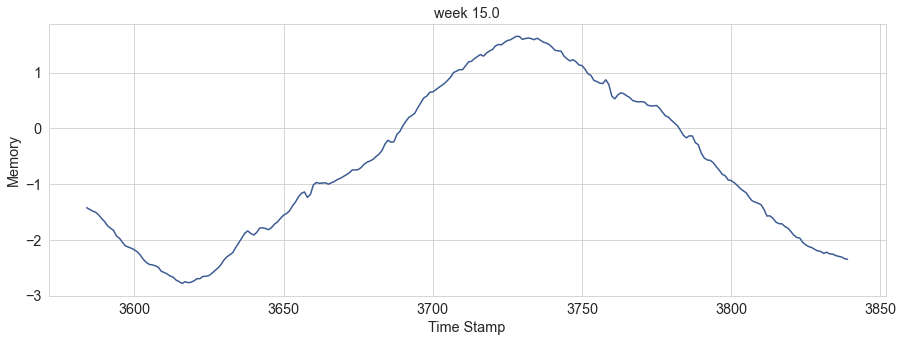

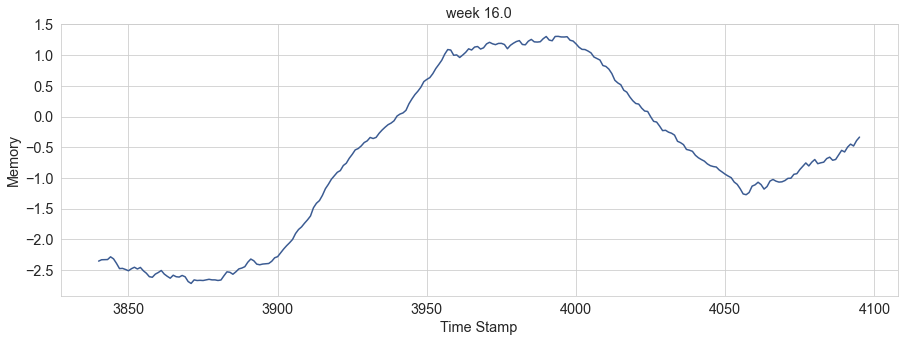

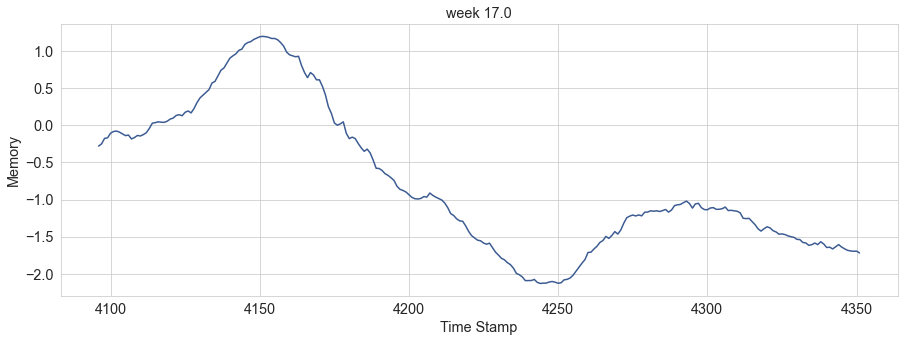

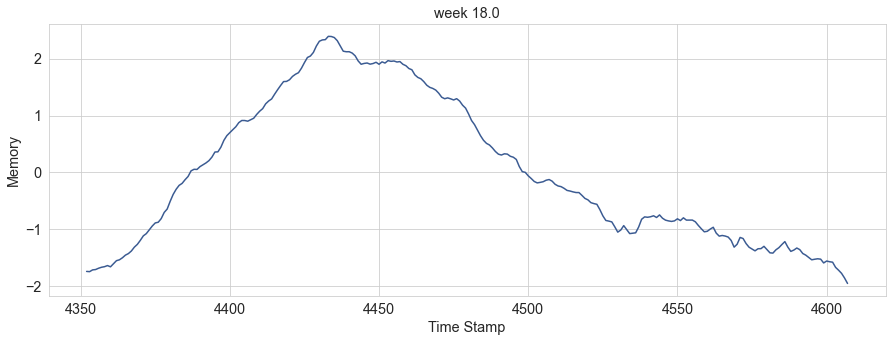

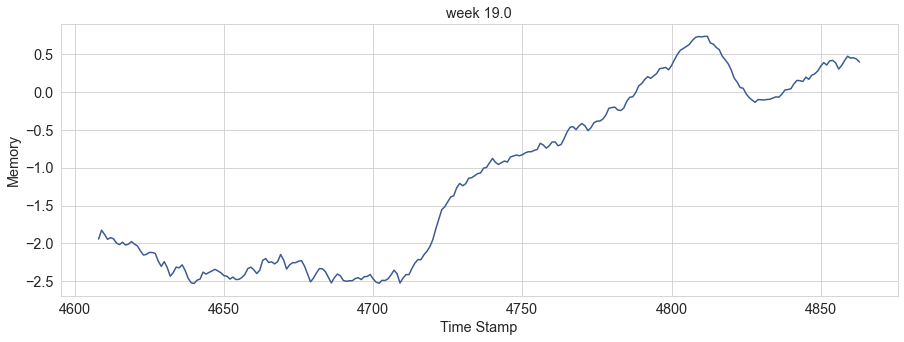

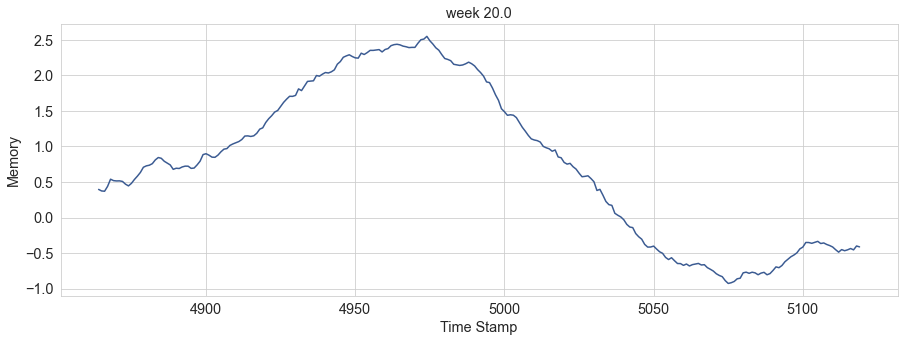

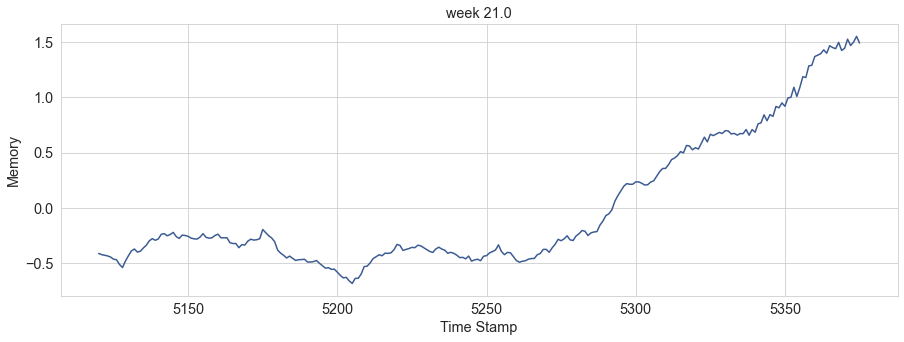

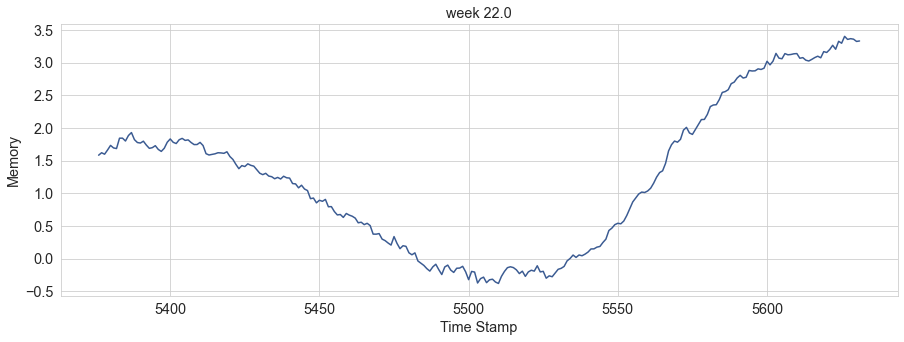

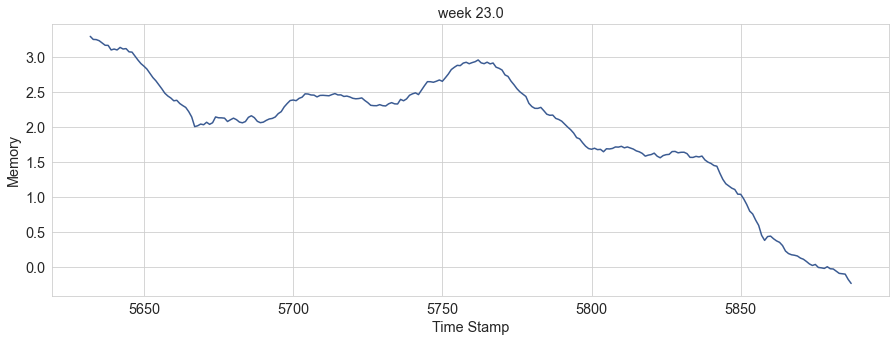

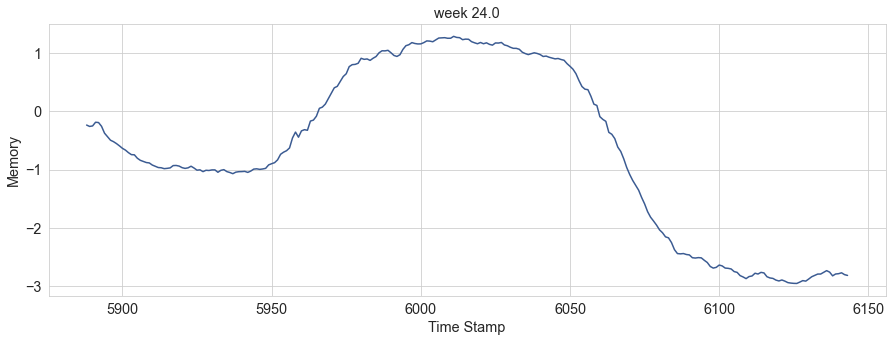

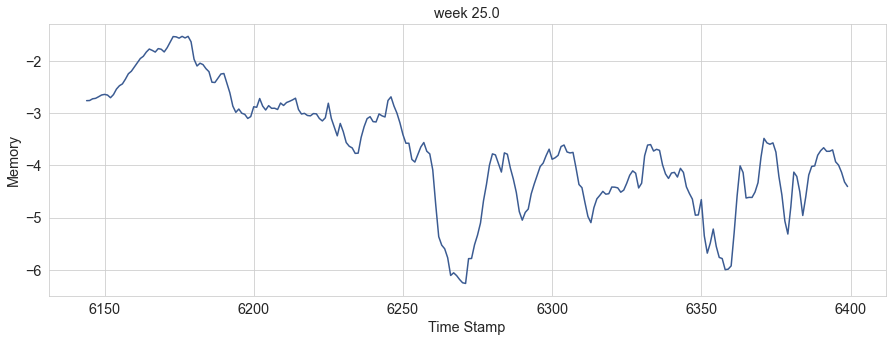

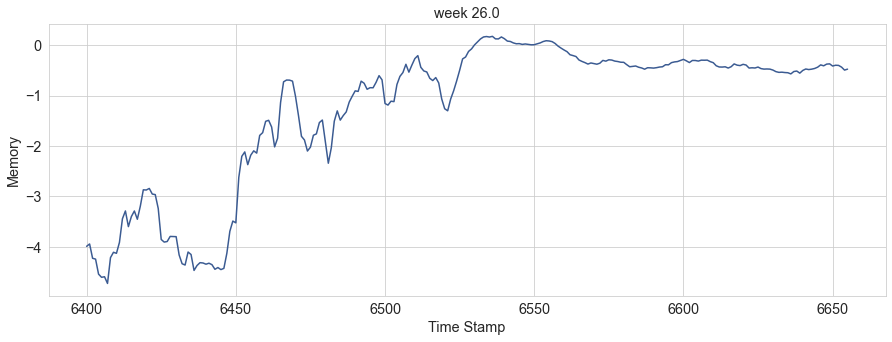

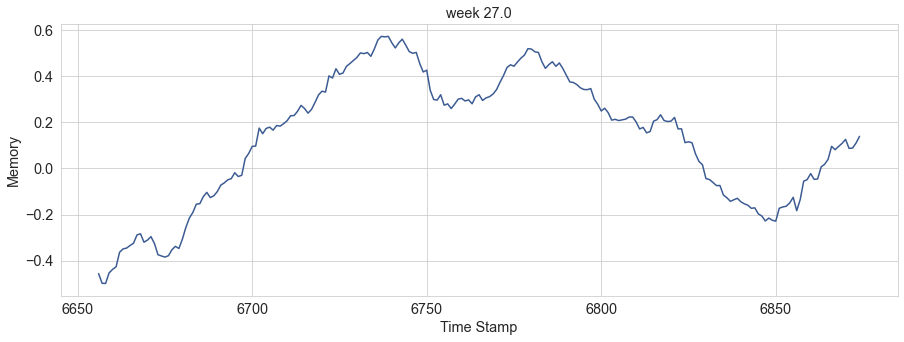

In [6]:
step = 256

for i in range(0,df.shape[0],step):
    fig = plt.figure(figsize=(15,5))
    tmp = df[i:i+step]['values'].plot(color=sns.xkcd_rgb["denim blue"])
    plt.title("turn %s"%(i/step +1))
    plt.xlabel('Time Stamp')
    plt.ylabel('Memory')
    plt.show()
    pp = PdfPages("turn_%s.pdf"%(i/step +1))
    pp.savefig(fig)
    pp.close()

In [7]:
anomaly_weeks = [25,26]
validation1_weeks = [10,11]
validation2_weeks = [23,24,25,26,27]
test_weeks = validation2_weeks

df_train_list = []
df_valid1_list = []
df_valid2_list = []
df_test_list = []

for i in range(0,df.shape[0],step):
    week = i/step +1
    if week in validation1_weeks:
        df_valid1_list.append(df[i:i+step]) 

    if week in validation2_weeks:
        if week in anomaly_weeks:
            df[i:i+step]['anomaly'] =1
        df_valid2_list.append(df[i:i+step])

    if week in test_weeks:
        if week in anomaly_weeks:
            df[i:i+step]['anomaly'] =1
        df_test_list.append(df[i:i+step])

    if week not in validation1_weeks and week not in validation2_weeks:
        print('week: ', week)
        df_train_list.append(df[i:i+step])

print(len(df_train_list))
print(len(df_valid1_list))
print(len(df_valid2_list))
print(len(df_test_list))

week:  1.0
week:  2.0
week:  3.0
week:  4.0
week:  5.0
week:  6.0
week:  7.0
week:  8.0
week:  9.0
week:  12.0
week:  13.0
week:  14.0
week:  15.0
week:  16.0
week:  17.0
week:  18.0
week:  19.0
week:  20.0
week:  21.0
week:  22.0
20
2
5
5
<ipython-input-7-cd588f2e86ab>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i:i+step]['anomaly'] =1
<ipython-input-7-cd588f2e86ab>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i:i+step]['anomaly'] =1


In [8]:
df_train = pd.concat(df_train_list)
df_test = pd.concat(df_test_list)
df_validation1 = pd.concat(df_valid1_list)
df_validation2 = pd.concat(df_valid2_list)
df_dict = {}
df_dict['train'] = df_train
df_dict['test'] = df_test
df_dict['validation1'] = df_validation1
df_dict['validation2'] = df_validation2

Size of train: (5120, 2)
Size of test: (1243, 2)
Size of validation1: (512, 2)
Size of validation2: (1243, 2)
Total: 8118
Ratio of train: 0.630697
Ratio of test: 0.153117
Ratio of validation1: 0.063070
Ratio of validation2: 0.153117


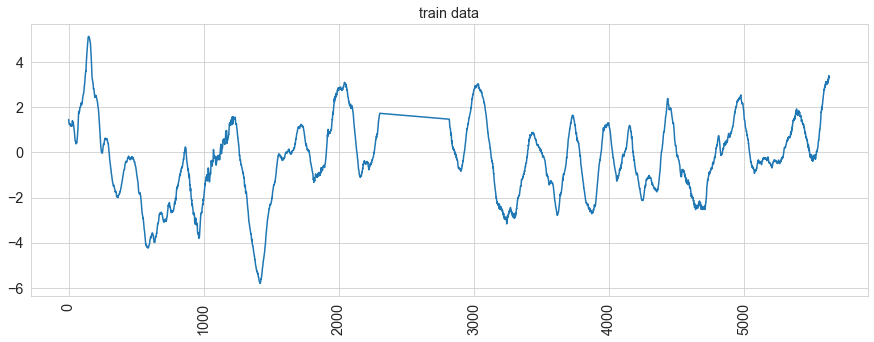

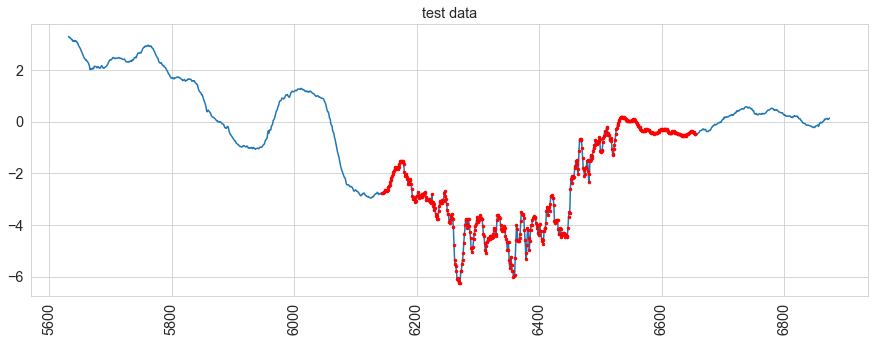

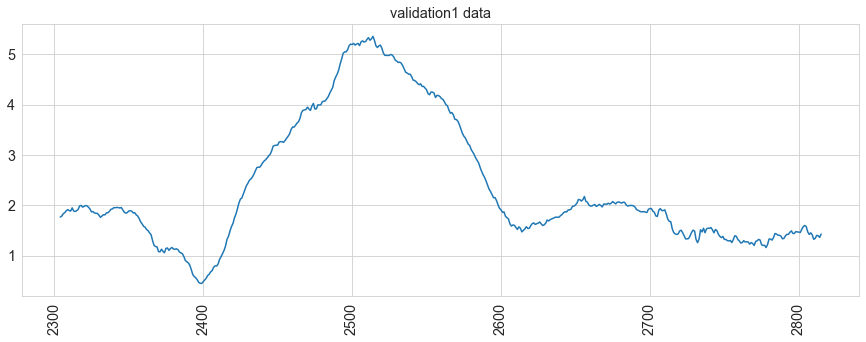

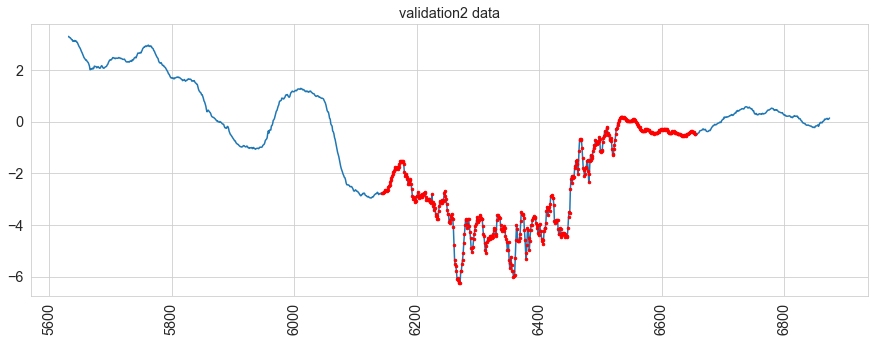

In [9]:
count = 0
for key in df_dict:
    print("Size of %s: %s"%(key,df_dict[key].shape))
    count += df_dict[key].shape[0]
print("Total: %d"%(count))

for key in df_dict:
    print("Ratio of %s: %f"%(key,float(df_dict[key].shape[0])/count))

for key in df_dict:
    plt.figure()
    df_tmp = df_dict[key]
    df_tmp['values'].plot(figsize=(15,5))
    rows = df_tmp[df_tmp.anomaly.isin([1])].itertuples()
    for row in rows:
        plt.plot(row[0], row[1], 'r.', markersize=5.0)
    plt.xticks(rotation='vertical')
    plt.title("%s data"%(key))
    plt.show()

In [10]:
for key in df_dict:
    np.save("../resources/data/discords/memory/%s"%(key),df_dict[key])

### Part 2: Prediction Modeling
Use python scripts: *lstm_predictor.py , stateful_lstm_predictor.py*.

### Part 3: Anomaly Detection

In [52]:
data_folder = "../resources/data/discords/memory/"

In [53]:
import numpy as np
#load training data
train_predictions = np.load(data_folder+"train_predictions.npy")
train_true = np.load(data_folder+"train_true.npy")
print(train_predictions.shape)
print(train_true.shape)

(5112, 3)
(5112,)


In [54]:
#load validation2 data
validation2_predictions = np.load(data_folder+"validation2_predictions.npy")
validation2_true = np.load(data_folder+"validation2_true.npy")
validation2_labels = np.load(data_folder+"validation2_labels.npy")
print(np.shape(validation2_predictions))
print(np.shape(validation2_true))
print(np.shape(validation2_labels))
validation2_labels = np.reshape(validation2_labels,[len(validation2_labels),np.shape(validation2_labels)[1]])
print(np.shape(validation2_labels))


(1235, 3)
(1235,)
(1235, 3, 1)
(1235, 3)


In [55]:
# load test data
test_predictions = np.load(data_folder+"test_predictions.npy")
test_true = np.load(data_folder+"test_true.npy")
test_labels = np.load(data_folder+"test_labels.npy")
print(np.shape(test_predictions))
print(np.shape(test_true))
test_labels = np.reshape(test_labels,[len(test_labels),np.shape(test_labels)[1]])
print(np.shape(test_labels))

(1235, 3)
(1235,)
(1235, 3)


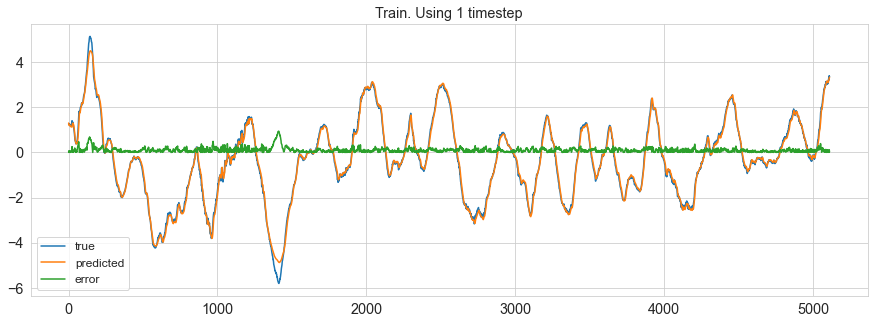

In [56]:
plt.figure(figsize=(15,5))
plt.plot(train_true,label='true')
plt.plot(train_predictions[:,0],label='predicted')
plt.plot(abs(train_true - train_predictions[:,0]),label='error')
plt.legend()
plt.title("Train. Using 1 timestep")
plt.show()

[0.00063984 0.00103808 0.00143884]
[[0.02119744 0.02465631 0.02771552]
 [0.02465631 0.02946377 0.03379926]
 [0.02771552 0.03379926 0.03948355]]


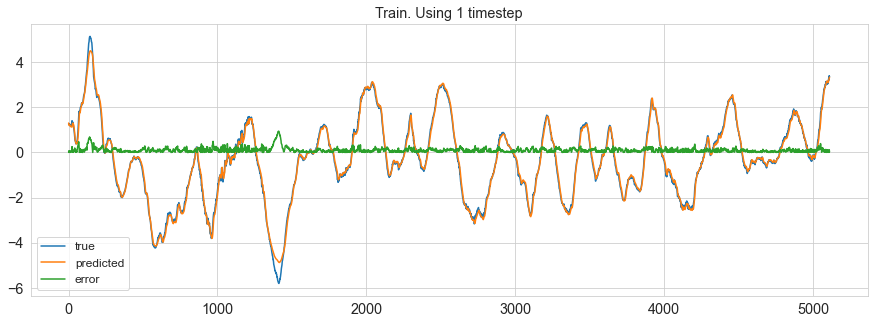

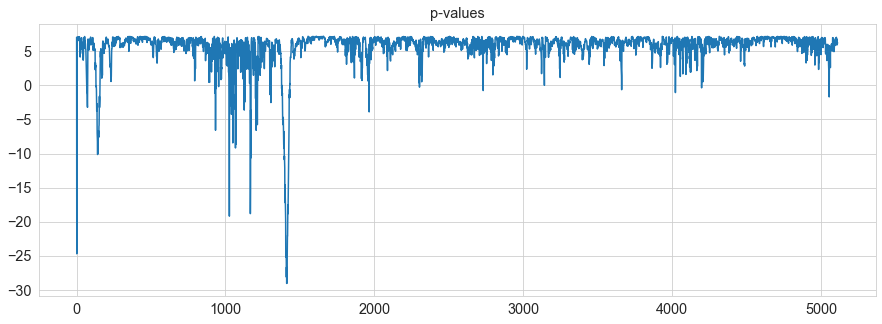

In [57]:
#error vectors
from scipy.stats import norm
from scipy.stats import multivariate_normal

train_error_vectors = np.zeros(np.shape(train_predictions))
n_cols = np.shape(train_predictions)[1]
for i in range(n_cols):
    train_error_vectors[:,i] =  train_true -train_predictions[:,i]

mean = np.mean(train_error_vectors, axis=0)
cov = np.cov(train_error_vectors,rowvar=False)
print(mean)
print(cov)
p_values= multivariate_normal.logpdf(train_error_vectors,mean,cov)

plt.figure(figsize=(15,5))
plt.plot(train_true,label='true')
plt.plot(train_predictions[:,0],label='predicted')
plt.plot(abs(train_true - train_predictions[:,0]),label='error')
plt.title("Train. Using 1 timestep")
plt.legend()

# plt.figure(figsize=(15,5))
# plt.plot(train_true,label='true')
# plt.plot(train_predictions[:,5],label='predicted')
# plt.plot(abs(train_true - train_predictions[:,5]),label='error')
# plt.title("Train. Using 6 timestep")
# plt.legend()

plt.figure(figsize=(15,5))
plt.plot(p_values)
plt.title("p-values")
plt.show()

train_errors_1 = train_true - train_predictions[:,0]

In [58]:
v2_error_vectors = np.zeros(np.shape(validation2_predictions))
for i in range(n_cols):
    v2_error_vectors[:,i] =  validation2_true -validation2_predictions[:,i]
v2_p_values= multivariate_normal.logpdf( v2_error_vectors,mean,cov)
# v2_true_anomalies = np.where(validation2_labels[:,0]==1)
# print "Validation2. Number True Anomalies: %d"%(np.shape(v2_true_anomalies)[1])
# print "Validation2. Location of anomalies: %s"%(v2_true_anomalies)
# print "validation2. True anomalies: %s"%(validation2_true[v2_true_anomalies])
# v2_thresholds =v2_p_values[v2_true_anomalies]
# print "validation2. p-values at true anomalies: %s"%(v2_thresholds)

# print 
test_error_vectors = np.zeros(np.shape(test_predictions))
for i in range(n_cols):
    test_error_vectors[:,i] =  test_true -test_predictions[:,i]
test_p_values= multivariate_normal.logpdf( test_error_vectors,mean,cov)
test_true_anomalies = np.where(test_labels[:,0]==1)
# print "Test. Number True Anomalies in: %d"%(np.shape(test_true_anomalies)[1])
# print "Test. Location of anomalies: %s"%(test_true_anomalies)
# print "Test. True anomalies: %s"%(test_true[test_true_anomalies])
# test_thresholds = test_p_values[test_true_anomalies]
# print "Test. p-values at true anomalies: %s"%(test_thresholds)




[600 605 614 624 625 626 627 628 629 630 631 632 633 634 635 636 645 646
 647 652 653 700 714 715 716 718 719 720 721 722 723 726 727 728 729 730
 731 732 734 736 739 740 741 742 744 745 746 747 750 753 769 776 781 782
 783 788 789 790 794 812 814 815 816 817 818 819 820 821 823 826 827 828
 829 830 831 832 833 834 835 836 837 838 839 840 841 843 844 845 846 847
 848 864 868 869 887 888 889]


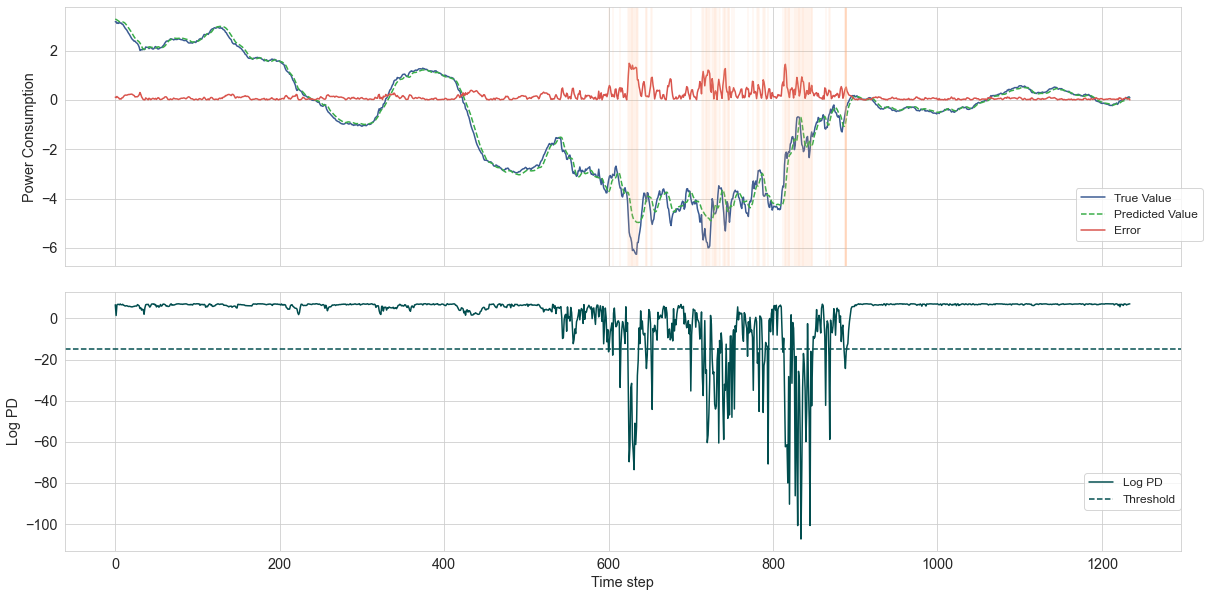

In [65]:
threshold_v2 = -15
f = plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=0.1)

v2_below_threshold = np.where(v2_p_values <= threshold_v2)
ax1 = plt.subplot(211)
ax1.plot(validation2_true,label='True Value',color=sns.xkcd_rgb["denim blue"])
ax1.plot(validation2_predictions[:,0],ls ='dashed',label='Predicted Value',color=sns.xkcd_rgb["medium green"])
ax1.plot(abs(validation2_true - validation2_predictions[:,0]),label='Error',color=sns.xkcd_rgb["pale red"])
for column in v2_below_threshold[0]:
    ax1.axvline(x=column,color=sns.xkcd_rgb["peach"],alpha=.1)
print(v2_below_threshold[0])
ax1.axvline(x=v2_below_threshold[0][-1],color=sns.xkcd_rgb["peach"],alpha=.5)
#for row in v2_true_anomalies:
#    plt.plot(row, validation2_true[row], 'r.', markersize=20.0)
ax1.legend(bbox_to_anchor=(1.02,.3),borderaxespad=0.,frameon=True)
plt.ylabel("Power Consumption")
#plt.title("Validation2. Using 1 timestep")


#plot v2 log PD
ax2 = plt.subplot(212, sharex=ax1)
ax2.plot(v2_p_values,label='Log PD',color=sns.xkcd_rgb["dark teal"])
ax2.axhline(y=threshold_v2,ls='dashed',label='Threshold',color=sns.xkcd_rgb["dark teal"])
ax2.legend(bbox_to_anchor=(1, .3), borderaxespad=0.,frameon=True)
plt.ylabel("Log PD")
#plt.title("Validation2 p-values")

#Set up the xlabel and xtick
#xticklabels = ax1.get_xticklabels() + ax2.get_xticklabels()
xticklabels = ax1.get_xticklabels()
plt.setp(xticklabels, visible=False)
plt.xlabel("Time step")
plt.show()
pp = PdfPages('power_v2.pdf')
pp.savefig(f)
pp.close()

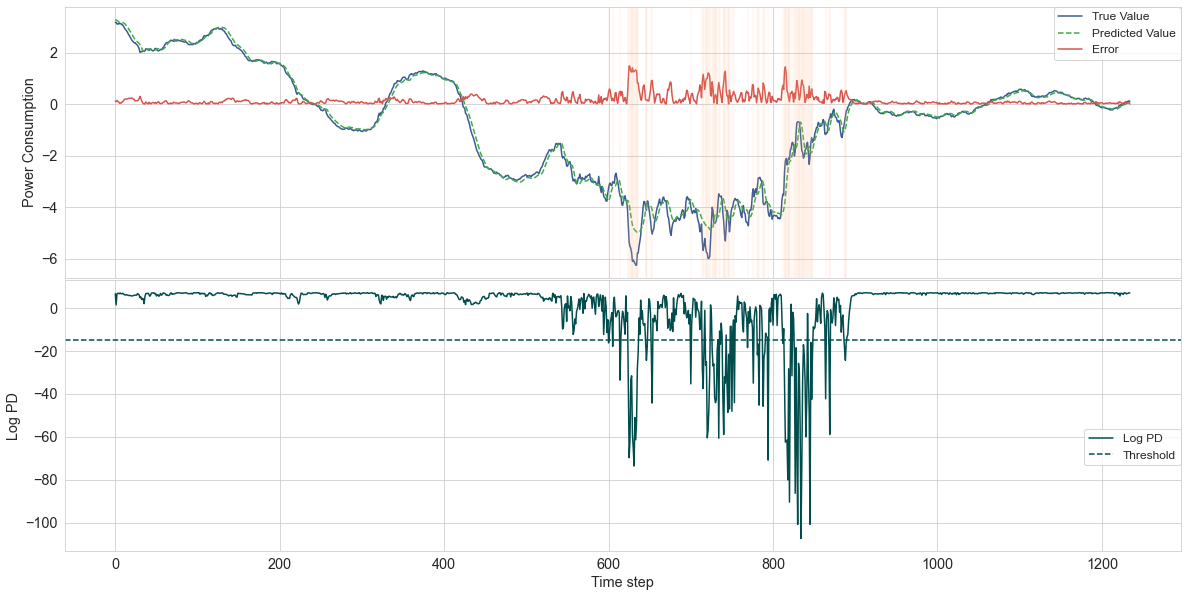

In [66]:
test_below_threshold = np.where(test_p_values <= threshold_v2)
#plot test data
f = plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=0.01)

ax1 = plt.subplot(211)
ax1.plot(test_true,label='True Value',color=sns.xkcd_rgb["denim blue"])
ax1.plot(test_predictions[:,0],ls ='dashed',label='Predicted Value',color=sns.xkcd_rgb["medium green"])
ax1.plot(abs(test_true - test_predictions[:,0]),label='Error',color=sns.xkcd_rgb["pale red"])
for column in test_below_threshold[0]:
    ax1.axvline(x=column,color=sns.xkcd_rgb["peach"],alpha=0.1)
#for row in test_true_anomalies:
#    plt.plot(row, test_true[row], 'r.', markersize=20.0)
ax1.legend(bbox_to_anchor=(1, 1), borderaxespad=0.,frameon=True)
plt.ylabel("Power Consumption")
#plt.title("Test. Using 1 timestep")

ax2 = plt.subplot(212, sharex=ax1)
ax2.plot(test_p_values,label='Log PD',color=sns.xkcd_rgb["dark teal"])
ax2.axhline(y=threshold_v2,ls='dashed',label='Threshold',color=sns.xkcd_rgb["dark teal"])
ax2.legend(bbox_to_anchor=(1, .45), borderaxespad=0.,frameon=True)
plt.ylabel("Log PD")
#plt.title("test p-values")

#Set up the xlabel and xtick
#xticklabels = ax1.get_xticklabels() + ax2.get_xticklabels()
xticklabels = ax1.get_xticklabels()
plt.setp(xticklabels, visible=False)
plt.xlabel("Time step")
plt.show()
pp = PdfPages('power_test.pdf')
pp.savefig(f)
pp.close()